# Starbucks Sentiment Analysis

## Objective of notebook

#### To produce sentiment analysis data of starbucks and find points of interests or potential ventures
Investigation shows the subreddit as space for Starbuck's associates and fans to share opinions and socialise.
This provided an oppurtunity to explore the general attitude towards the brand as well as potential points of interests to explore.

## Target Data

- The comments of the first 200 posts on the Starbucks subreddit will be investigated

## Method

- Collect data via API call from Reddit
- Clean data to perform sentiment analysis
- Explore data to identify patterns

#### Relevent files:

- **StarbucksComments_VaderSentiment.csv** - *Sentiment score with the Vader Package*

- **StarbucksComments_TextblobSentiment.csv** - *Sentiment score with the Textblob Package*

- **Starbucks_post_Dataset.csv** - *Starbucks subreddit Posts dataset for quicker setup of project*

- **Starbucks_Replies_Dataset.csv** - *Starbucks subreddit Comments dataset for quicker setup of project*



# 1. Building Database

#### Gathering Data

List of all imported packages

In [1]:
import re # regular expressions for filtering and cleaning data
import api_funcs # api calling from reddit
import nltk # to process text
import random 
import pandas as pd 
import wordcloud # to find text frequency
import matplotlib.pyplot as plt # for plotting
import seaborn as sns; sns.set() # visualisations
import numpy as np

from sklearn.model_selection import train_test_split # for training classifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer # for converting text to arrays
from sklearn.naive_bayes import MultinomialNB, GaussianNB # for custom classifiers
from sklearn import metrics
from textblob.sentiments import NaiveBayesAnalyzer, PatternAnalyzer # to apply textblob Analysis
from textblob import Blobber
from nltk.sentiment.vader import SentimentIntensityAnalyzer, VaderConstants # Vader - Pre-built seniment analysis package
from wordcloud import WordCloud, STOPWORDS # for ignoring stop words when finding word frequency
from api_funcs import * # api call functions
from nltk.collocations import * # data cleaning - using bigrams
from nltk.stem import PorterStemmer # for stemming words
from nltk.corpus import stopwords # for filtering out stop words in text

#### Getting data through API calling

In [2]:
from api_funcs import * # function for reddit api call
posts = subreddit_posts('starbucks', 200) 
posts.shape

(200, 6)

In [3]:
posts

,Title,URL,Body,Upvotes,Time,Key
0,I can’t manage this dude. I just can’t. This p...,https://www.reddit.com/r/starbucks/comments/iu...,,748,2020-09-18 02:08:33,0
1,[OC by Brettybooop] Caption This,https://www.reddit.com/r/starbucks/comments/iu...,,1002,2020-09-17 14:20:28,1
2,Caramel macchiato pls.,https://www.reddit.com/r/starbucks/comments/iu...,I don’t even work for Starbucks anymore but th...,62,2020-09-18 00:27:19,2
3,i forget how to think when the manager is watc...,https://www.reddit.com/r/starbucks/comments/it...,,1970,2020-09-17 04:36:28,3
4,I did a thing,https://www.reddit.com/r/starbucks/comments/iu...,,25,2020-09-18 03:26:34,4
...,...,...,...,...,...,...
195,Can anyone point me in the direction of the sc...,https://www.reddit.com/r/starbucks/comments/it...,My store uses crew to give us the schedule but...,2,2020-09-16 09:45:01,195
196,"2020, you’ve gone too far....",https://www.reddit.com/r/starbucks/comments/is...,,122,2020-09-15 11:03:09,196
197,How to determine calories for customizations?,https://www.reddit.com/r/starbucks/comments/it...,I really would like to know how customizing th...,0,2020-09-16 13:09:09,197
198,What to expect from a panel interview? Previou...,https://www.reddit.com/r/starbucks/comments/it...,Hello! I just got off the phone with a SM who ...,2,2020-09-16 09:18:13,198


In [ ]:
# Save Dataset for faster test/setup
posts.to_csv('Starbucks_Post_Dataset.csv', index=False)

In [4]:
# From API call function
replies = replies_to_posts(posts)
replies.shape

(2254, 4)

In [5]:
replies.head(3)

,Reply,Upvote,Time,Key
0,I AGREE. this company has the ability to staff...,195.0,2020-09-18 02:20:11,0.0
1,My Target Starbucks ALWAYS has people working ...,73.0,2020-09-18 02:56:20,0.0
2,Long ass post incoming.\n\nTLDR: I scolded my ...,131.0,2020-09-18 02:52:33,0.0


In [ ]:
replies.to_csv('Starbucks_Replies_Dataset.csv', index=False)

In [7]:
replies.shape

(2254, 4)

#### Cleaning Data

In [8]:
# For test/setup purposes, saved csv shall be used instead of calling API
Posts = pd.read_csv('Starbucks_Post_Dataset.csv')
Comments = pd.read_csv('Starbucks_Replies_Dataset.csv')

##### Removing any empty data

In [9]:
Comments.dropna(subset=['Reply'], inplace=True)

##### 'comments' shall be replies in text only

In [10]:
Comments.Reply.head(5)

0    22 March 2020 Update:\n\n[The incentive has be...
1    Hi partners, checking in here from my doctor o...
2    Thank you for all your hard work keeping this ...
3    I mentioned this in another thread, but my sto...
4    Everyone in my store but one person took the l...
Name: Reply, dtype: object

##### Removing Links in text

In [11]:
Comments.Reply =  Comments.Reply.apply(lambda x: re.sub(r'\(?http\S+', '', x))

##### Removing punctuations and symbols

In [12]:
Comments.Reply = Comments.Reply.apply(lambda x: re.sub(r'[^\w\s]', '', x))

##### Removing items in text such as "/n" by tokenizing

- ***replies.Reply*** will be used for sentiment analysis
- ***Concat_replies*** to ***Tokenized_replies*** to ***Concat_Tokenized_replies*** will be used for wordcloud

##### Applying tokenization in Reply column

In [13]:
Comments.Reply = Comments.Reply.apply(lambda x: ' '.join(nltk.word_tokenize(x)))

In [14]:
# Saving for test/setup process.
Comments.to_csv('PreProcessed_Starbucks_Comments.csv', index=False)

#### Pre-processing for wordcloud

In [15]:
Comments = pd.read_csv('PreProcessed_Starbucks_Comments.csv')
Comments.head(3)

,Reply,Upvote,Time,Key
0,22 March 2020 Update The incentive has been an...,1.0,2020-03-23 09:44:57,0.0
1,Hi partners checking in here from my doctor or...,80.0,2020-03-22 07:27:09,0.0
2,Thank you for all your hard work keeping this ...,96.0,2020-03-22 05:09:09,0.0


In [16]:
# joining all the words into one line
Comments_Concat = Comments.Reply.str.cat(sep='. ')
Comments_Concat[:100]

'22 March 2020 Update The incentive has been announced 3 pay raise for now until 20 April 2020 Please'

In [17]:
# from one line of text, tokenizing to remove text such as \n 
Comments_Tokenized = nltk.word_tokenize(Comments_Concat)
Comments_Tokenized

['22',
 'March',
 '2020',
 'Update',
 'The',
 'incentive',
 'has',
 'been',
 'announced',
 '3',
 'pay',
 'raise',
 'for',
 'now',
 'until',
 '20',
 'April',
 '2020',
 'Please',
 'read',
 'this',
 'comment',
 'its',
 'very',
 'important',
 'has',
 'more',
 'info',
 'thank',
 'you',
 'uFetchFox98',
 'another',
 'important',
 'edit',
 'There',
 'was',
 'a',
 'letter',
 'released',
 'on',
 'Workplacethe',
 'Hub',
 'screenshots',
 'are',
 'not',
 'okay',
 'but',
 'I',
 'did',
 'type',
 'the',
 'whole',
 'thing',
 'up',
 'HERE',
 'verbatim',
 'with',
 'the',
 'link',
 'to',
 'the',
 'Hub',
 'If',
 'it',
 'doesnt',
 'work',
 'let',
 'me',
 'know',
 'it',
 'may',
 'be',
 'missing',
 'an',
 'underscore',
 '24',
 'March',
 '2020',
 'EXPANDED',
 'FOODDRINK',
 'BENEFIT',
 'ANNOUNCEMENT',
 'big',
 'ups',
 'to',
 'uF1_Phantom',
 '1',
 'April',
 '2020',
 'Catastrophe',
 'Pay',
 'and',
 'Service',
 'Pay',
 '3',
 'bonus',
 'extended',
 'through',
 'to',
 'May',
 '3rd',
 'Sneaky',
 'fuckers',
 'edited',

Concatinate tokenized comments

In [18]:
# joining all text again together with unwanted text removed
Comments_Tokenized_Concat = ' '.join(Comments_Tokenized)
Comments_Tokenized_Concat[:100]

'22 March 2020 Update The incentive has been announced 3 pay raise for now until 20 April 2020 Please'

#### Using bigrams to find words that have different meaning when paired

In [19]:
from nltk.collocations import *

def common_bigrams(tokenized_text, min_freq, top_n):
    bigram_measures = nltk.collocations.BigramAssocMeasures()
    finder = BigramCollocationFinder.from_words(tokenized_text)
    
    # to adjust frequency requiremnts for bigrams to be recgonised
    finder.apply_freq_filter(min_freq) 
    finder.nbest(bigram_measures.pmi, top_n)
    return finder.nbest(bigram_measures.pmi, top_n)

# Returning 10 highest PMI bigrams
print(common_bigrams(Comments_Tokenized, 10, 10))

[('cinnamon', 'dolce'), ('air', 'quality'), ('US', 'MORE'), ('Good', 'luck'), ('PAY', 'US'), ('green', 'bean'), ('passion', 'tea'), ('wan', 'na'), ('gon', 'na'), ('tip', 'jar')]


# 2. Investigate the data

### Using Wordcloud to identify frequent words

##### Importing relevant wordcloud packages

In [20]:
import wordcloud
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

In [21]:
import random
def grey_color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    return "hsl(0, 0%%, %d%%)" % random.randint(1, 20)

##### Using word cloud to also filter out frequent text that may be irrelevant

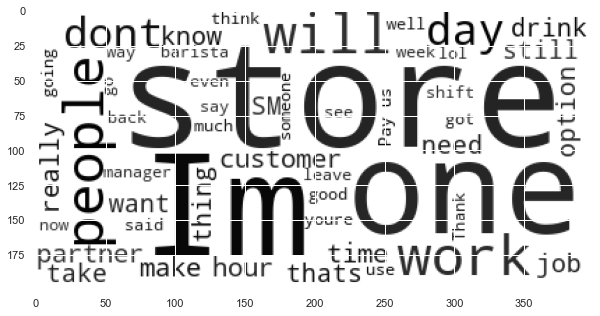

In [22]:
stp = STOPWORDS.copy()
# filtering out text
stp.add('Starbucks')

wc = WordCloud(background_color="white", max_words=50,  stopwords=stp)
# generate word cloud
wc.generate(Comments_Tokenized_Concat)

plt.figure(figsize=(10,20))
plt.imshow(wc.recolor(color_func=grey_color_func, random_state=3))
plt.show()

###### Tuning filter to filter out text that looks irrelavant

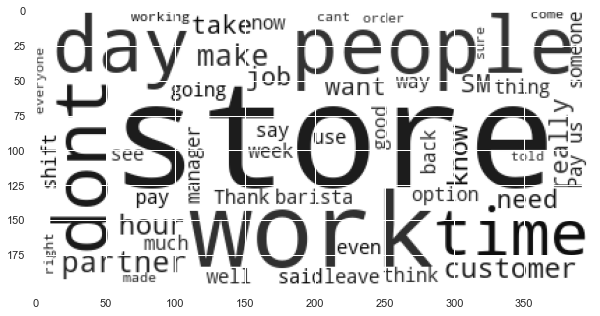

In [23]:
stp = STOPWORDS.copy()
# filtering out text
stp.add('Starbucks')
stp.add('Im')
stp.add('One')
stp.add('thats')
stp.add('still')
stp.add('lol')
stp.add('will')
stp.add('drink')
stp.add('got')
stp.add('go')
stp.add('youre')

wc = WordCloud(background_color="white", max_words=50,  stopwords=stp)
# generate word cloud
wc.generate(Comments_Tokenized_Concat)

plt.figure(figsize=(10,20))
plt.imshow(wc.recolor(color_func=grey_color_func, random_state=3))
plt.show()

## Notes:
- worth investigating employee's experience on the job.
- Worth exploring relationship between "pay", "Manager", "Pay us", "work", "job" and "leave"?
- Time elements involved? "Shift", "hour", "time", "week", "day" etc...
- Investigate why "partner" would be involved. Could help with optimising product for target audience?
- Possible miscommunication/ misinformation? ("know", "think", "working")
- Staff morale/ relationships with peer? ("thank", "said")

# 3. Performing Sentiment Analysis

### Goal is to explore the data with the use of different packages such as:
- Vader (pre-built)
- Textblob (Pre-built)
- Custom Trained

### 3.1 Using Vader

In [24]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer, VaderConstants

#initializing VADER for Python script
sid = SentimentIntensityAnalyzer()

##### Creating dictionary for manually assigning sentiment score for jargons/ informal terms.
Further investigation of trends can allow such tuning

In [ ]:
# new_words = {
#    'pay us': -300
# }
#
# sid.lexicon.update(new_words)
#

##### Setting up dataset for sentiment analysis (Vader)

- For setting up the project, **Starbucks_Replies_Dataset.csv** shall be used.
- For updated posts/results, the **API call function** shall be used instead.

In [25]:
# Saved csv file
Comments = pd.read_csv('Starbucks_Replies_Dataset.csv')

# API call function
# posts = subreddit_posts('starbucks', 200) 
# posts.shape

Comments.head(3)

,Reply,Upvote,Time,Key
0,22 March 2020 Update:\n\n[The incentive has be...,1.0,2020-03-23 09:44:57,0.0
1,"Hi partners, checking in here from my doctor o...",80.0,2020-03-22 07:27:09,0.0
2,Thank you for all your hard work keeping this ...,96.0,2020-03-22 05:09:09,0.0


#####  Preparing data for Vader

In [26]:
# Pre-process functions
Comments.Reply = Comments.Reply.apply(lambda x: re.sub(r'\(?http\S+', '', x))
Comments.Reply = Comments.Reply.apply(lambda x: re.sub(r'[^\w\s]', '', x))
Comments.Reply = Comments.Reply.apply(lambda x: ' '.join(nltk.word_tokenize(x)))

In [27]:
Comments.head(3)

,Reply,Upvote,Time,Key
0,22 March 2020 Update The incentive has been an...,1.0,2020-03-23 09:44:57,0.0
1,Hi partners checking in here from my doctor or...,80.0,2020-03-22 07:27:09,0.0
2,Thank you for all your hard work keeping this ...,96.0,2020-03-22 05:09:09,0.0


##### Creating then filling "neg", "neu", "pos" and "compound" columns while applying Vader to Reply column of data

In [28]:
Comments[['neg','neu','pos','compound']] = Comments.Reply.apply(lambda x: pd.Series(sid.polarity_scores(x)))

In [29]:
Comments.head(3)

,Reply,Upvote,Time,Key,neg,neu,pos,compound
0,22 March 2020 Update The incentive has been an...,1.0,2020-03-23 09:44:57,0.0,0.153,0.719,0.128,-0.6487
1,Hi partners checking in here from my doctor or...,80.0,2020-03-22 07:27:09,0.0,0.062,0.798,0.140,0.9600
2,Thank you for all your hard work keeping this ...,96.0,2020-03-22 05:09:09,0.0,0.056,0.643,0.301,0.7269


In [ ]:
# Saving vader sentiment results
Comments.to_csv('StarbucksComments_VaderSentiment.csv', index=False)

##### Exploring sentiment grades and mean values

In [30]:
# In hopes of consistency, Vader analysed comments will be saved first, then reloaded before performing analysis
Comments_Vader = pd.read_csv('StarbucksComments_VaderSentiment.csv')
Comments_Vader

,Reply,Upvote,Time,Key,neg,neu,pos,compound
0,22 March 2020 Update The incentive has been an...,1.0,2020-03-23 09:44:57,0.0,0.153,0.719,0.128,-0.6487
1,Hi partners checking in here from my doctor or...,80.0,2020-03-22 07:27:09,0.0,0.062,0.798,0.140,0.9611
2,Thank you for all your hard work keeping this ...,96.0,2020-03-22 05:09:09,0.0,0.056,0.643,0.301,0.7269
3,I mentioned this in another thread but my stor...,34.0,2020-03-22 05:15:44,0.0,0.076,0.739,0.184,0.9050
4,Everyone in my store but one person took the l...,20.0,2020-03-22 06:26:28,0.0,0.155,0.845,0.000,-0.6310
...,...,...,...,...,...,...,...,...
2931,A venerated Virginian barista,7.0,2020-09-14 14:28:44,198.0,0.000,1.000,0.000,0.0000
2932,yall should just blast it during happy hourdou...,5.0,2020-09-14 14:54:39,198.0,0.000,0.802,0.198,0.5719
2933,BOOM goes the timer watch the chai and steamed...,4.0,2020-09-14 20:36:11,198.0,0.000,1.000,0.000,0.0000
2934,I scrolled down quickly and honestly I dont ev...,3.0,2020-09-14 10:16:31,199.0,0.000,0.750,0.250,0.7184


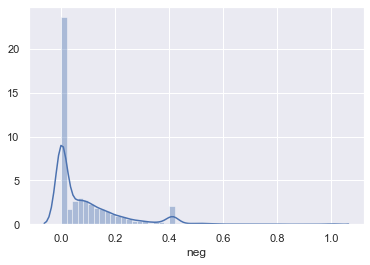

In [31]:
sns.distplot(Comments_Vader["neg"])

In [32]:
Comments_Vader["neg"].mean()

0.09182595367847442

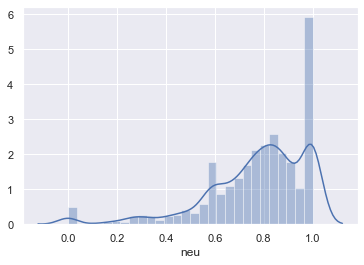

In [33]:
sns.distplot(Comments_Vader["neu"])

In [34]:
Comments_Vader["neu"].mean()

0.7731927792915512

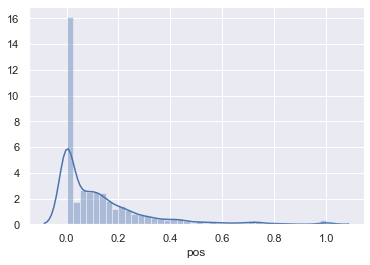

In [35]:
sns.distplot(Comments_Vader["pos"])

In [36]:
Comments_Vader["pos"].mean()

0.12783957765667578

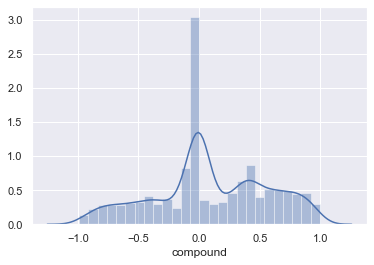

In [37]:
sns.distplot(Comments_Vader["compound"])

In [38]:
Comments_Vader["compound"].mean()

0.09862755449591291

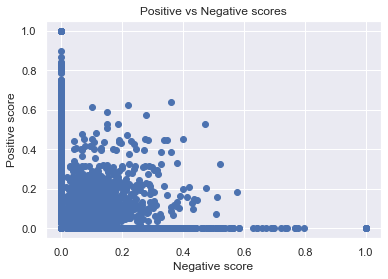

In [39]:
# Overview visualisation of Vader Sentiment Analysis

plt.scatter(Comments_Vader["neg"],Comments_Vader["pos"])
plt.title('Positive vs Negative scores')
plt.xlabel('Negative score')
plt.ylabel('Positive score')
plt.show()

### Notes:

- Data shows overall sentiment grades to be slightly positive
- Pie chart would be good to visualise distribution

### 3.2 Using Textblob

In [40]:
from textblob.sentiments import NaiveBayesAnalyzer, PatternAnalyzer
from textblob import Blobber
tba = Blobber(analyzer=NaiveBayesAnalyzer())

#####  Setting up dataset for sentiment analysis (Textblob)

- For setting up the project, **Starbucks_Replies_Dataset.csv** shall be used.
- For updated posts/results, the **API call function** shall be used instead.

In [41]:
# Saved csv file
Comments = pd.read_csv('Starbucks_Replies_Dataset.csv')

# API call function
# posts = subreddit_posts('starbucks', 200) 
# posts.shape

Comments.head(3)

,Reply,Upvote,Time,Key
0,22 March 2020 Update:\n\n[The incentive has be...,1.0,2020-03-23 09:44:57,0.0
1,"Hi partners, checking in here from my doctor o...",80.0,2020-03-22 07:27:09,0.0
2,Thank you for all your hard work keeping this ...,96.0,2020-03-22 05:09:09,0.0


##### Preparing data for Textblob

In [42]:
# Pre-process functions
Comments.Reply = Comments.Reply.apply(lambda x: re.sub(r'\(?http\S+', '', x))
Comments.Reply = Comments.Reply.apply(lambda x: re.sub(r'[^\w\s]', '', x))
Comments.Reply = Comments.Reply.apply(lambda x: ' '.join(nltk.word_tokenize(x)))

##### Creating then filling "classification", "positive' and "negative" columns while applying Textblob to Reply column of data

In [43]:
Comments[['Classification','positive','negative']] = Comments.Reply.apply(lambda x: pd.Series({'Classification':tba(x).sentiment[0],
                                                                        'positive':tba(x).sentiment[1],
                                                                        'negative':tba(x).sentiment[2]}))

In [44]:
Comments.head(5)

,Reply,Upvote,Time,Key,Classification,positive,negative
0,22 March 2020 Update The incentive has been an...,1.0,2020-03-23 09:44:57,0.0,pos,0.798205,0.201795
1,Hi partners checking in here from my doctor or...,80.0,2020-03-22 07:27:09,0.0,neg,0.021248,0.978752
2,Thank you for all your hard work keeping this ...,96.0,2020-03-22 05:09:09,0.0,pos,0.901818,0.098182
3,I mentioned this in another thread but my stor...,34.0,2020-03-22 05:15:44,0.0,pos,0.737362,0.262638
4,Everyone in my store but one person took the l...,20.0,2020-03-22 06:26:28,0.0,pos,0.877318,0.122682


In [ ]:
# Saving vader sentiment results
Comments.to_csv('StarbucksComments_TextBlobSentiment.csv', index=False)

##### Finding mean sentiment grades

In [45]:
Comments_Textblob = pd.read_csv('StarbucksComments_TextBlobSentiment.csv')
Comments_Textblob

,Reply,Upvote,Time,Key,Classification,positive,negative
0,22 March 2020 Update:\n\n[The incentive has be...,1.0,2020-03-23 09:44:57,0.0,pos,0.569990,0.430010
1,"Hi partners, checking in here from my doctor o...",80.0,2020-03-22 07:27:09,0.0,pos,0.518725,0.481275
2,Thank you for all your hard work keeping this ...,96.0,2020-03-22 05:09:09,0.0,pos,0.901818,0.098182
3,"I mentioned this in another thread, but my sto...",34.0,2020-03-22 05:15:44,0.0,pos,0.709396,0.290604
4,Everyone in my store but one person took the l...,20.0,2020-03-22 06:26:28,0.0,pos,0.877318,0.122682
...,...,...,...,...,...,...,...
2931,A venerated Virginian (barista)?,7.0,2020-09-14 14:28:44,198.0,pos,0.500000,0.500000
2932,yall should just blast it during happy hour/do...,5.0,2020-09-14 14:54:39,198.0,pos,0.658605,0.341395
2933,"BOOM goes the timer, watch the chai and steame...",4.0,2020-09-14 20:36:11,198.0,neg,0.003367,0.996633
2934,I scrolled down quickly and honestly I don't e...,3.0,2020-09-14 10:16:31,199.0,neg,0.225390,0.774610


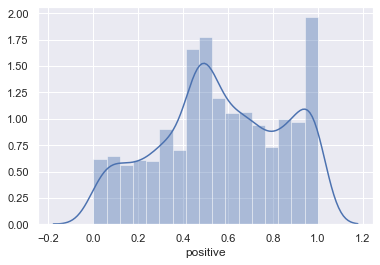

In [46]:
sns.distplot(Comments_Textblob["positive"])

In [47]:
Comments_Textblob["positive"].mean()

0.5653510162963103

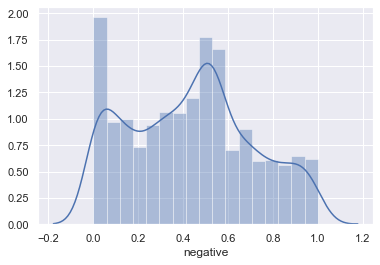

In [48]:
sns.distplot(Comments_Textblob["negative"])

In [49]:
Comments_Textblob["negative"].mean()

0.43464898370368993

### Notes:

- Data shows overall sentiment grades to be slightly positive
- quick glance at classification could easily misinterperate overall sentiment grade is positive
- Pie Chart would be good to visualise distribution of scores

### 3.3 Using custom trained package (naive bayes sentiment classifier)

In [50]:
from sklearn.model_selection import train_test_split # for splitting data to train and test

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer # converting text into matrix
from sklearn.naive_bayes import MultinomialNB # using Multinomial Naive bayes
from sklearn import metrics
from nltk.corpus import stopwords # for filtering out stop words in text
from nltk.stem import PorterStemmer # for stemming words

#####  Creating dataset with sentiment analysis results ()

- To compare results with Vader Sentiment analysis package

In [51]:
Comments_Vader = pd.read_csv('StarbucksComments_VaderSentiment.csv')
Comments_Vader

,Reply,Upvote,Time,Key,neg,neu,pos,compound
0,22 March 2020 Update The incentive has been an...,1.0,2020-03-23 09:44:57,0.0,0.153,0.719,0.128,-0.6487
1,Hi partners checking in here from my doctor or...,80.0,2020-03-22 07:27:09,0.0,0.062,0.798,0.140,0.9611
2,Thank you for all your hard work keeping this ...,96.0,2020-03-22 05:09:09,0.0,0.056,0.643,0.301,0.7269
3,I mentioned this in another thread but my stor...,34.0,2020-03-22 05:15:44,0.0,0.076,0.739,0.184,0.9050
4,Everyone in my store but one person took the l...,20.0,2020-03-22 06:26:28,0.0,0.155,0.845,0.000,-0.6310
...,...,...,...,...,...,...,...,...
2931,A venerated Virginian barista,7.0,2020-09-14 14:28:44,198.0,0.000,1.000,0.000,0.0000
2932,yall should just blast it during happy hourdou...,5.0,2020-09-14 14:54:39,198.0,0.000,0.802,0.198,0.5719
2933,BOOM goes the timer watch the chai and steamed...,4.0,2020-09-14 20:36:11,198.0,0.000,1.000,0.000,0.0000
2934,I scrolled down quickly and honestly I dont ev...,3.0,2020-09-14 10:16:31,199.0,0.000,0.750,0.250,0.7184


##### Cleaning Data for training

In [52]:
Comments_Vader.dropna(subset=['Reply'], inplace=True)

In [53]:
Comments_Vader.Reply = Comments.Reply.apply(lambda x: re.sub(r'[^\w\s]', '', x) ) 

In [54]:
stopwords = stopwords.words('english')
Comments_Vader.Reply = Comments_Vader.Reply.apply(
    lambda x: ' '.join([word for word in nltk.word_tokenize(x) if word.lower() not in stopwords])
)

In [55]:
Comments_Vader.Reply = Comments_Vader.Reply.apply(lambda x: re.sub(r'\(?http\S+', '', x))

In [56]:
lemmatizer = nltk.WordNetLemmatizer()

In [57]:
Comments_Vader.Reply = Comments_Vader.Reply.apply(lambda x: ' '.join([lemmatizer.lemmatize(word) for word in nltk.word_tokenize(x)]))

##### Transforming text to Matrix

In [58]:
vectorizer = CountVectorizer()

In [59]:
Comments.dropna(subset=['Reply'], inplace=True)
X = vectorizer.fit_transform(Comments_Vader.Reply)

In [60]:
nb = MultinomialNB()

#nb.fit(features_matrix, item_we_want_to_predict)
nb.fit(X, Comments_Vader.compound)

ValueError: Unknown label type: (array([-0.6487,  0.9611,  0.7269, ...,  0.    ,  0.7184,  0.    ]),)